<a href="https://colab.research.google.com/github/ChoiDae1/Youtube_Project/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/SKT-AI/KoBART#egg=kobart

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import os 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AdamW

from tqdm import tqdm

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/유튜브 썸네일 크롤링/전처리_data(이모지 그대로).csv",index_col=0)
#data.drop(['channel_name','title','date','thumbnail','videoId','URL'],axis=1,inplace=True)

In [ ]:
data.shape

(54454, 16)

In [ ]:
data.columns

Index(['channel_name', 'title', 'date', 'thumbnail', 'videoId', 'URL',
       'viewCount', 'likeCount', 'commentCount', 'subscriber', 'category',
       'date_diff', 'title_symbol', 'noun', 'preprocessed_title', 'views_bin'],
      dtype='object')

In [ ]:
data.head(2)

,channel_name,title,date,thumbnail,videoId,URL,viewCount,likeCount,commentCount,subscriber,category,date_diff,title_symbol,noun,preprocessed_title,views_bin
0,피지컬갤러리,전직 UDT. 특수부대 학원에 가다! (숨참기 8분 30초 ㄷㄷ...?) | 달려라...,2019-11-23,https://i.ytimg.com/vi/tV1Dc-LCZJw/hqdefault.jpg,tV1Dc-LCZJw,https://www.youtube.com/watch?v=tV1Dc-LCZJw,11610712,62590.0,5187.0,3070000,스포츠_운동,911,9,7,전직 udt 특수부대 학원에 가다 ! 숨참기 8분 30초 ㄷㄷ ? 달려라 김계란 e...,700
1,피지컬갤러리,110만 유튜버 해외여행 클라스.. ㄷㄷ,2019-11-04,https://i.ytimg.com/vi/bPCriDPI4Oc/hqdefault.jpg,bPCriDPI4Oc,https://www.youtube.com/watch?v=bPCriDPI4Oc,8770917,54094.0,7249.0,3070000,스포츠_운동,93,2,3,110만 유튜버 해외여행 클라스 ㄷㄷ,700


In [ ]:
use_data = data[['preprocessed_title','views_bin', 'subscriber', 'date_diff', 'category']] #모델 훈련에 사용할 애들만 추출
use_data = use_data.reset_index()

In [ ]:
#결측치 확인
use_data.isnull().sum()

index                   0
preprocessed_title      0
views_bin               0
subscriber              0
date_diff             157
category                0
dtype: int64

In [ ]:
#결측치 제거
use_data = use_data.dropna(axis=0) #date_diff의 결측치 제거
use_data = use_data.reset_index()
use_data.isnull().sum()

level_0               0
index                 0
preprocessed_title    0
views_bin             0
subscriber            0
date_diff             0
category              0
dtype: int64

In [ ]:
#date_diff에 int로 변환이 안되는 값 존재함
drop_idxs = []
for idx, elem in enumerate(list(use_data['date_diff'])):
    try:
      elem = int(elem)
    except:
      drop_idxs.append(idx)

print(len(drop_idxs))

63


In [ ]:
use_data = use_data.drop(drop_idxs, axis=0)

In [ ]:
use_data.head()

,level_0,index,preprocessed_title,views_bin,subscriber,date_diff,category
0,0,0,전직 udt 특수부대 학원에 가다 ! 숨참기 8분 30초 ㄷㄷ ? 달려라 김계란 e...,700,3070000,911,스포츠_운동
1,1,1,110만 유튜버 해외여행 클라스 ㄷㄷ,700,3070000,93,스포츠_운동
2,2,2,푸쉬업 이렇게 제발 하지마세요 팔꿈치 박살,700,3070000,1218,스포츠_운동
3,3,3,북한 잠수함에 권총 한 자루를 들고간 udt 작전 실화 with 유병호 준위,700,3070000,993,스포츠_운동
4,4,4,udt vs 프로 파이터들 달려라 김계란 ep2 팀매드 체육관 인턴 1부,700,3070000,967,스포츠_운동


In [ ]:
from sklearn.preprocessing import LabelEncoder

#조회수 구간 -> 범주형 변수로 만들기
le = LabelEncoder()
result = le.fit_transform(use_data['views_bin'])
use_data['views_bin'] = result

In [ ]:
data.views_bin.value_counts() #범주형 변수로 변환하기 전 조회수 구간

250    11942
1      10933
30     10793
100    10608
700    10178
Name: views_bin, dtype: int64

In [ ]:
use_data.views_bin.value_counts() #변환한 후 조회수 구간

3    11936
1    10769
0    10760
2    10591
4    10178
Name: views_bin, dtype: int64

In [ ]:
#카테고리 변수 -> 범주형 변수로 변환
le = LabelEncoder()
result = le.fit_transform(use_data['category'])
use_data['category'] = result

In [ ]:
data.category.value_counts() #범주형 변수로 변환하기 전 카테고리 변수

반려애완동물    9883
education           9586
뉴스/정치/사회            9516
주식부동산경제             9144
스포츠_운동              8819
IT_컴퓨터              7506
Name: category, dtype: int64

In [ ]:
use_data.category.value_counts() #변환한 후 카테고리 변수 

2    9883
1    9586
3    9394
5    9051
4    8819
0    7501
Name: category, dtype: int64

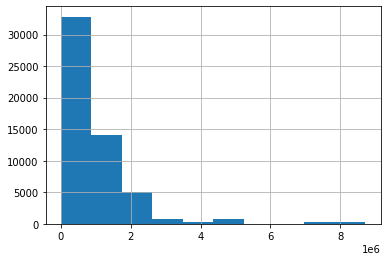

In [ ]:
use_data.subscriber.hist() # 얘를 정규화하거나 범주형으로 만들어서 넣어줘야할듯--> 아무나 시도 ㄱㄱ

## train, val, test 데이터 분리

In [ ]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(use_data, test_size = 0.1, shuffle=True, random_state=34) #일단 9:1 비율로 train, test 데이터 나눔
print(len(train_dataset))
print(len(test_dataset))

48810
5424


In [ ]:
train_dataset, val_dataset  = train_test_split(train_dataset, test_size = 0.2, shuffle=True, random_state=34) #이후 train data를 8:2 비율로 train, val 데이터 추가로 나눔
print(len(train_dataset))
print(len(val_dataset))

39048
9762


In [ ]:
train_dataset.preprocessed_title.iloc[37]

'위기는 기회 ? 코로나19로 체제 강화 노리는 북한 ytn'

# Tokenization

In [ ]:
from transformers import BartModel
from kobart import get_pytorch_kobart_model, get_kobart_tokenizer

tokenizer = get_kobart_tokenizer()
model = BartModel.from_pretrained(get_pytorch_kobart_model())
inputs = tokenizer([train_dataset.preprocessed_title.iloc[37]], return_tensors='pt')
#model(inputs['input_ids'])

using cached model. /content/.cache/kobart_base_tokenizer_cased_cf74400bce.zip
using cached model. /content/.cache/kobart_base_cased_ff4bda5738.zip


In [ ]:
ex1 = tokenizer.encode(train_dataset.preprocessed_title.iloc[37])
tokenizer.convert_ids_to_tokens(ex1)

['▁위',
 '기는',
 '▁기회',
 '▁?',
 '▁코',
 '로',
 '나',
 '19',
 '로',
 '▁체제',
 '▁강화',
 '▁노',
 '리는',
 '▁북한',
 '▁y',
 't',
 'n']

In [ ]:
# train, val에 사용
class Train_Val_Dataset(Dataset):

    def __init__(self, df,max_seq_len=64):
        self.data = df
        self.tokenizer = get_kobart_tokenizer()
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):

        record = self.data.iloc[index]
        text, table, label = str(record["preprocessed_title"]), record[['subscriber', 'date_diff','category']],int(record["views_bin"])
        tokens = (
            [self.tokenizer.bos_token]
            + self.tokenizer.tokenize(text)
            + [self.tokenizer.eos_token]
        )
        encoder_input_id = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(encoder_input_id)
        if len(encoder_input_id) < self.max_seq_len:
            while len(encoder_input_id) < self.max_seq_len:
                encoder_input_id += [self.tokenizer.pad_token_id]
                attention_mask += [0]
        else:
            encoder_input_id = encoder_input_id[: self.max_seq_len - 1] + [
                self.tokenizer.eos_token_id
            ]
            attention_mask = attention_mask[: self.max_seq_len]
        return {
            "input_text": np.array(encoder_input_id, dtype=np.int_),
            "input_table": np.array(table, dtype=np.int_),
            "attention_mask": np.array(attention_mask, dtype=float),
            "labels": np.array(label, dtype=np.int_),
        }
    def __len__(self):
        return len(self.data)
    
# test 예측에 사용
class TestDataset(Dataset):

    def __init__(self, df,max_seq_len=64):
        self.data = df
        self.tokenizer = get_kobart_tokenizer()
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):

        record = self.data.iloc[index]
        text, table = str(record["preprocessed_title"]), record[['subscriber', 'date_diff','category']]
        tokens = (
            [self.tokenizer.bos_token]
            + self.tokenizer.tokenize(text)
            + [self.tokenizer.eos_token]
        )
        encoder_input_id = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(encoder_input_id)
        if len(encoder_input_id) < self.max_seq_len:
            while len(encoder_input_id) < self.max_seq_len:
                encoder_input_id += [self.tokenizer.pad_token_id]
                attention_mask += [0]
        else:
            encoder_input_id = encoder_input_id[: self.max_seq_len - 1] + [
                self.tokenizer.eos_token_id
            ]
            attention_mask = attention_mask[: self.max_seq_len]
        return {
            "input_ids": np.array(encoder_input_id, dtype=np.int_),
            "input_table": np.array(table, dtype=np.int_),
            "attention_mask": np.array(attention_mask, dtype=float),
        }


    def __len__(self):
        return len(self.data)

In [ ]:
TRAIN_BATCH_SIZE = 24 # batch size가 클수록 global minimum에 도달하는 속도가 증가합니다. (GPU 메모리에 따라 변경해 주세요, 너무 크면 OOM 문제가 발생합니다.)
TEST_BATCH_SIZE = 1

In [ ]:
train_data = Train_Val_Dataset(train_dataset)
val_data = Train_Val_Dataset(val_dataset)
test_data = TestDataset(test_dataset)

# batch_size 만큼 데이터 분할
train_dataloader = DataLoader(train_data,
                                batch_size=TRAIN_BATCH_SIZE,
                                shuffle=True)

val_dataloader = DataLoader(val_data,
                            batch_size=TRAIN_BATCH_SIZE,
                            shuffle=False) #drop_last=True

test_dataloader = DataLoader(test_data,
                                batch_size=TEST_BATCH_SIZE,
                                shuffle=False)



print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

using cached model. /content/.cache/kobart_base_tokenizer_cased_cf74400bce.zip
using cached model. /content/.cache/kobart_base_tokenizer_cased_cf74400bce.zip
using cached model. /content/.cache/kobart_base_tokenizer_cased_cf74400bce.zip
1627
407
5424


In [ ]:
train_data.__getitem__(3)

{'attention_mask': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'input_table': array([2170000,     512,       1]),
 'input_text': array([    0, 22444, 11300, 14489, 16609, 12024, 20386, 11921, 14461,
        15691, 14460, 14460, 11853, 11300, 16069, 13090, 16211,     1,
            3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,
            3]),
 'labels': array(4)}

## 모델링
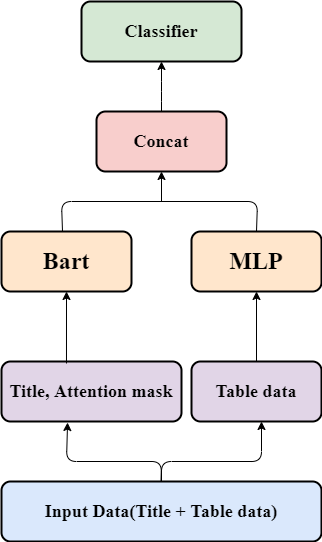

In [ ]:
import torch.nn as nn
import torch
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BartForSequenceClassification

In [ ]:
bart = BartModel.from_pretrained(get_pytorch_kobart_model())
bart.eval()

using cached model. /content/.cache/kobart_base_cased_ff4bda5738.zip


BartModel(
  (shared): Embedding(30000, 768, padding_idx=3)
  (encoder): BartEncoder(
    (embed_tokens): Embedding(30000, 768, padding_idx=3)
    (embed_positions): BartLearnedPositionalEmbedding(1028, 768, padding_idx=3)
    (layers): ModuleList(
      (0): BartEncoderLayer(
        (self_attn): BartAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): BartEncoderLayer(
        (self_attn): BartAttention(
   

In [ ]:
dataiter = iter(train_dataloader)
batch = dataiter.next()
#outs = model(input_ids = batch["input_ids"], attention_mask=batch["attention_mask"],labels=batch['labels'])
outs = bart(input_ids = batch["input_text"], attention_mask=batch["attention_mask"])
print(outs.keys())

odict_keys(['last_hidden_state', 'past_key_values', 'encoder_last_hidden_state'])


In [ ]:
outs['last_hidden_state'].shape

torch.Size([24, 64, 768])

In [ ]:
hidden_states = outs['last_hidden_state']
hidden_states = hidden_states.view(hidden_states.size(0),-1,hidden_states.size(-1))[ :, -1, :] #.shape # classification의 head # eos token은 없는걸로~,,
hidden_states.shape #(batch, 768)

torch.Size([24, 768])

In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim): # input_dim
        super(Classifier, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Sequential(nn.Linear(input_dim, input_dim//2),
                                    nn.ReLU(),
                                    nn.Linear(input_dim//2, input_dim//4),
                                    nn.ReLU(),
                                    nn.Linear(input_dim//4, output_dim))
    def forward(self, x):
        output = self.linear(x)
        return output

In [ ]:
class FinalModel(nn.Module):
    def __init__(self, table_dim, num_label):  # table_dim은 정형데이터의 column 수라 생각하면 됨
        super(FinalModel, self).__init__()
        self.text_extractor = bart 
        self.table_extractor = nn.Sequential(nn.Linear(table_dim, 768//2),
                                             nn.ReLU(),
                                             nn.Linear(768//2, 768),
                                             nn.ReLU())
        self.classifier = Classifier(768 * 2, num_label)
    
    def forward(self, x):
        text_input = x['input_text'] 
        attention_input = x['attention_mask']
        table_input = x['input_table'].float() # (batch_size, table_dim)
        text_feature = self.text_extractor(text_input, attention_input)['last_hidden_state'] # (batch_size, 768)
        text_feature =  text_feature.view(text_feature.size(0),-1,text_feature.size(-1))[ :, -1, :]
        table_feature = self.table_extractor(table_input) # (batch_size, 768)
        fusion_input = torch.cat([text_feature, table_feature], dim = 1) # (batch_size, 768 * 2)
        output = self.classifier(fusion_input)
        return output



In [ ]:
model = FinalModel(table_dim=3, num_label=5) # 현재 사용하는 정형데이터 feature 수는 3개이므로 table_dim=3

In [ ]:
dataiter = iter(train_dataloader)
batch = dataiter.next()
out = model(batch)
out.shape

torch.Size([24, 5])

## 모델 훈련

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
#훈련을 위한 함수
def train_function(model, optimizer, loss_func, num_epochs):
    loss_array = []
    for i in range(num_epochs):
        for j, batch_data in enumerate(train_dataloader):
            x = batch_data
            for key, value in x.items():
                 x[key] = x[key].to(device)
            y = batch_data['labels'].to(device)
        
            optimizer.zero_grad()
            output = model(x)
            loss = loss_func(output,y)
            loss.backward()
            optimizer.step()
            
        loss_array.append(loss.data.cpu().detach().numpy())
        print(f'epoch{i+1} training loss: {loss.data}') # 1epoch 마다 loss 출력
        test_function(model)
        
    return loss_array

In [ ]:
#validation셋에 대해 정확도 출력하는 함수
def test_function(model):
    correct =0
    total = 0

    with torch.no_grad():
        for batch_data in val_dataloader:
            x = batch_data
            for key, value in x.items():
                 x[key] = x[key].to(device)
            y = batch_data['labels'].to(device)
            output=model(x)
            _, pred = torch.max(output,axis=1)#가장 큰 값과 인덱스 반환
            total += y.shape[0]
            correct += torch.sum(pred==y)
        print('Accuracy of Test Data:{}%'.format(100*(correct/total)))  

In [ ]:
#loss history를 받을때, 이를 그래프로 시각화하는 함수
import matplotlib.pyplot as plt

def show_loss(loss_history):
    plt.plot(loss_history)
    plt.xlabel('epoch')
    plt.ylabel('train_loss')
    plt.show()

In [ ]:
NUM_EPOCHS = 5
LR = 1e-3
TABLE_DIM = 3
NUM_LABELS = 5

In [ ]:
import torch.optim as optim

model = FinalModel(table_dim=TABLE_DIM, num_label=NUM_LABELS).to(device) # 현재 사용하는 정형데이터 feature 수는 3개이므로 table_dim=3
loss_func = nn.CrossEntropyLoss() #이 안에 이미 softmax가 구현되어 있음
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
train_losses = train_function(model, optimizer, loss_func, NUM_EPOCHS)

epoch1 training loss: 1.632022500038147
Accuracy of Test Data:21.501741409301758%
epoch2 training loss: 1.6218563318252563
Accuracy of Test Data:21.501741409301758%
epoch3 training loss: 1.6106992959976196
Accuracy of Test Data:21.501741409301758%
epoch4 training loss: 1.6214712858200073
Accuracy of Test Data:21.501741409301758%
epoch5 training loss: 1.6151684522628784
Accuracy of Test Data:21.501741409301758%


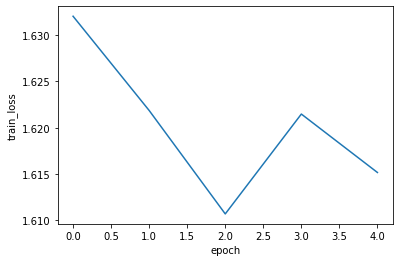

In [ ]:
# epoch마다 loss 시각화
show_loss(train_losses)

## 모델 테스트

In [ ]:
# test 결과 확인
test_function(model)

Accuracy of Test Data:21.501741409301758%
